In [307]:
from datetime import datetime, timedelta
import requests
import time
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def clamp(value, min_value, max_value):
    return max(min_value, min(value, max_value))

def toutc(x):
    local_time = datetime.utcfromtimestamp(x)
    return local_time.strftime("%Y-%m-%d %H %M %S")

from datetime import datetime, timezone

def utc_to_unix(utc_str: str, fmt: str = "%Y-%m-%d %H:%M:%S") -> int:
    dt = datetime.strptime(utc_str, fmt)
    dt = dt.replace(tzinfo=timezone.utc)
    return int(dt.timestamp())

In [ ]:
def get_orderbooks_events(start_time, end_time, pair):

    API_KEY = ""
    
    data = []

    while start_time < end_time:
        
        url = f"https://api.amberdata.com/markets/futures/order-book-events/{pair}"
        querystring = {"exchange":"binance","startDate":start_time}

        headers = {
        "x-api-key": API_KEY,
        "Accept-Encoding": "gzip, deflate, br"
        }

        resp = requests.get(url, headers=headers, params=querystring)

        data += resp.json()['payload']['data']
        
        time.sleep(0.5)
        start_time = int(resp.json()['payload']['data'][-1]['exchangeTimestamp'])
        end_time = int(end_time)

        print(resp.json()['payload']['data'][-1]['exchangeTimestamp'])
        
    return data

In [381]:
def get_orderbook(time, pair):

    url = f"https://api.amberdata.com/markets/futures/order-book-snapshots/{pair}"

    querystring = {"exchange":"binance","startDate":time,"endDate":time + 60, "maxLevel":"50"}

    headers = {
        "x-api-key": "UAKb9c56d95f63436dc0b533f30abcf7d9c",
        "Accept-Encoding": "gzip, deflate, br"
    }

    response = requests.get(url, headers=headers, params=querystring)

    return response.json()['payload']['data']

In [382]:
def ob_5s(ob, events):
    ans_ob = [copy.deepcopy(ob[0])]
    curr_time = ob[0]['timestamp'] // 1000 + 5

    ob = copy.deepcopy(ob[0])

    st = time.time()
    sec = 60
    for i in range(len(events)):
        if (events[i]['exchangeTimestamp'] // 1000 >= curr_time):
            curr_time += 5
            ob['timestamp'] = curr_time
            ob_add = copy.deepcopy(ob)
            ans_ob.append(ob_add)

        for j in events[i]['ask']:
            check = False

            for k in range(len(ob['ask'])):
                if j['price'] == ob['ask'][k]['price']:
                    ob['ask'][k]['volume'] = j['volume']
                    check = True
                    break

            if check == False:
                ob['ask'].append(j)

        for j in events[i]['bid']:
            check = False

            for k in range(len(ob['bid'])):
                if j['price'] == ob['bid'][k]['price']:
                    ob['bid'][k]['volume'] = j['volume']
                    check = True
                    break

            if check == False:
                ob['bid'].append(j)

        t = time.time()
        if st + sec < t:
            print(i)
            print(len(ans_ob))
            st = t


        ob['ask'] = sorted(ob['ask'], key=lambda d: d['price'])
        ob['bid'] = sorted(ob['bid'], key=lambda d: d['price'], reverse=True)

        
        for j in range(len(ob['ask'])):
            if ob['ask'][j]['volume'] != 0:
                ob['ask'] = ob['ask'][j:j+300]
                break

        for j in range(len(ob['bid'])):
            if ob['bid'][j]['volume'] != 0:
                ob['bid'] = ob['bid'][j:j+300]
                break
    
    return ans_ob

In [ ]:
def get_spot_tickers(start_time, end_time, pair, exchange):

    API_KEY = ""

    data = []

    while start_time < end_time:
        
        url = f"https://api.amberdata.com/markets/spot/trades/{pair}"
        querystring = {"exchange":exchange,"startDate":start_time}

        headers = {
            "x-api-key": API_KEY,
            "Accept-Encoding": "gzip, deflate, br"
        }

        resp = requests.get(url, headers=headers, params=querystring)

        data += resp.json()['payload']['data']
        
        time.sleep(0.5)
        
        start_time = int(resp.json()['payload']['data'][-1]['exchangeTimestamp'])
        end_time = int(end_time)
        
    return data

In [384]:
def get_price_spot_5s(start_time, tickers, h):
    ans_price = [tickers[0]['price']]
    curr_time = start_time + 5
    curr_price = tickers[0]['price']

    i = 0
    while i < len(tickers):
        if (tickers[i]['exchangeTimestamp'] // 1000 == curr_time):
                curr_time += 5
                ans_price.append(curr_price)
                curr_price = tickers[i]['price']
        elif (tickers[i]['exchangeTimestamp'] // 1000 > curr_time):
            if (tickers[i]['exchangeTimestamp'] // 1000 < curr_time + 5):
                curr_time += 5
                ans_price.append(curr_price)
                curr_price = tickers[i]['price']
                i += 1
            else:
                ans_price.append(curr_price)
                curr_time += 5
        else:
            curr_price = tickers[i]['price']
            i += 1

        if (len(ans_price) >= 12 * 60 * h):
             break

    while(len(ans_price) < 12 * 60 * h):
        ans_price.append(ans_price[-1])

    return np.array(ans_price)

In [385]:
def funding_rate_5s(orderbook_fut, price_index, max_leverage):
    impact_margin = 200 * max_leverage
    
    def impact_price(side):
        p_i = 0
        result = []

        for j in range(len(orderbook_fut)):
            price_quant = 0
            quant_sum = 0
            
            for i in range(len(orderbook_fut[j][side])): # исправил
                ob = orderbook_fut[j][side]
                
                price_quant += ob[i]['price'] * ob[i]['volume']
                quant_sum += ob[i]['volume']
                
                if price_quant > impact_margin:
                    price_quant -= ob[i]['price'] * ob[i]['volume']
                    quant_sum -= ob[i]['volume']
                    p_i = i
                    break
                    
            result.append(impact_margin / ((impact_margin - price_quant) / orderbook_fut[j][side][p_i]['price'] + quant_sum))
        return result
    
    
    def premium_index(impact_bid, impact_ask):
        ans = []
        for i in range(len(impact_bid)):
            ans.append((max(0, impact_bid[i] - price_index[i]) - max(0, price_index[i] - impact_ask[i])) / price_index[i])
        return ans
    
    n = 12 * 60 * 8
    interest_rate = 0.01 / 100
    funding_r = []
    average_prem_index = []

    def average_pi(prem_index):
        sum_index = 0
        for i in range(len(prem_index)):
            sum_index += (i + 1) * prem_index[i]
        return sum_index / sum(np.arange(1, len(prem_index) + 1))
    

    impact_bid = impact_price('bid')
    impact_ask = impact_price('ask')
    prem_index = premium_index(impact_bid, impact_ask)
    
    j = 0
    for i in range(0, len(prem_index), n):
        average_prem_index.append(average_pi(prem_index[i:i+n]))
        rate = average_prem_index[j] + clamp(interest_rate - average_prem_index[j], -0.0005, 0.0005) # исправить
        j += 1
        funding_r.append(rate)
    
    return funding_r, prem_index, impact_bid, impact_ask

In [315]:
start_time = "1758585600000"
end_time = "1758614400000"
pair = "BCHUSDT"

data_bch = get_orderbooks_events(start_time, end_time, pair)
ob = get_orderbook(int(start_time) // 1000, pair)

obs = ob_5s(ob, data_bch)

1758585788653
1758585979455
1758586165853
1758586360727
1758586557863
1758586739874
1758586924649
1758587110363
1758587296626
1758587492547
1758587683798
1758587886321
1758588087342
1758588280945
1758588475108
1758588669915
1758588867018
1758589065497
1758589267633
1758589459360
1758589671122
1758589875957
1758590066787
1758590263268
1758590470463
1758590677692
1758590878282
1758591091719
1758591298660
1758591513892
1758591725240
1758591946925
1758592156571
1758592354865
1758592546522
1758592754011
1758592946488
1758593142292
1758593337605
1758593517567
1758593693842
1758593879707
1758594068167
1758594269130
1758594467435
1758594648945
1758594831490
1758595014028
1758595205877
1758595408143
1758595594934
1758595780146
1758595972854
1758596151320
1758596333797
1758596510941
1758596678830
1758596850145
1758597023855
1758597195878
1758597368637
1758597539377
1758597707238
1758597883199
1758598056291
1758598238991
1758598412649
1758598582588
1758598765604
1758598952323
1758599132726
175859

In [316]:
h = 8
pair = "bch_usdt"

spot_tick_bin = get_spot_tickers(start_time, end_time, pair, "binance")
spot_tick_okx = get_spot_tickers(start_time, end_time, pair, "okex")
spot_tick_gate = get_spot_tickers(start_time, end_time, pair, "gateio")
spot_tick_kucoin = get_spot_tickers(start_time, end_time, pair, "kucoin")

bch_5s_bin = get_price_spot_5s(int(start_time) // 1000, spot_tick_bin, h)
bch_5s_okx = get_price_spot_5s(int(start_time) // 1000, spot_tick_okx, h)
bch_5s_gate = get_price_spot_5s(int(start_time) // 1000, spot_tick_gate, h)
bch_5s_kucoin = get_price_spot_5s(int(start_time) // 1000, spot_tick_kucoin, h)

bch_index = 0.6451 * bch_5s_bin + 0.1935 * bch_5s_okx + 0.0645 * bch_5s_gate + 0.0969 * bch_5s_kucoin

In [387]:
fr, prem_index, bid, ask = funding_rate_5s(obs[:len(bch_index)], bch_index, 75)

In [388]:
np.array(fr) * 100

array([-0.00538657])

In [ ]:
def calculate_funding(start_time, end_time, pair1, pair2, max_leverage):
    data_bch = get_orderbooks_events(start_time, end_time, pair1)
    ob = get_orderbook(int(start_time) // 1000, pair1)

    obs = ob_5s(ob, data_bch)

    spot_tick_bin = get_spot_tickers(start_time, end_time, pair2, "binance")
    spot_tick_okx = get_spot_tickers(start_time, end_time, pair2, "okex")
    spot_tick_gate = get_spot_tickers(start_time, end_time, pair2, "gateio")
    spot_tick_kucoin = get_spot_tickers(start_time, end_time, pair2, "kucoin")

    h = 8

    bch_5s_bin = get_price_spot_5s(int(start_time) // 1000, spot_tick_bin, h)
    bch_5s_okx = get_price_spot_5s(int(start_time) // 1000, spot_tick_okx, h)
    bch_5s_gate = get_price_spot_5s(int(start_time) // 1000, spot_tick_gate, h)
    bch_5s_kucoin = get_price_spot_5s(int(start_time) // 1000, spot_tick_kucoin, h)

    bch_index = 0.6451 * bch_5s_bin + 0.1935 * bch_5s_okx + 0.0645 * bch_5s_gate + 0.0969 * bch_5s_kucoin

    return funding_rate_5s(obs[:len(bch_index)], bch_index, max_leverage)


In [345]:
obs_1 = copy.deepcopy(obs)

In [334]:
def float_order(orders, obs):
    for order in orders:
        time_make = utc_to_unix(order['time_make'])
        time_cancel = 1e10
        if order['time_cancel'] != 0:
            time_cancel = utc_to_unix(order['time_cancel'])

        for j in range(len(obs)):
            if (obs[j]['timestamp'] >= time_make and time_cancel > obs[j]['timestamp']):
                if order['side'] == 'buy':
                    price = obs[j]['bid'][0]['price'] * (1 - order['percent'] / 100)
                    obs[j]['bid'].append({'price': price, 'volume': order['volume'] / price})
                    obs[j]['bid'] = sorted(obs[j]['bid'], key=lambda d: d['price'], reverse=True)

                elif order['side'] == 'sell':
                    price = obs[j]['ask'][0]['price'] * (1 - order['percent'] / 100)
                    obs[j]['ask'].append({'price': price, 'volume': order['volume'] / price})
                    obs[j]['ask'] = sorted(obs[j]['ask'], key=lambda d: d['price'])

    return obs

In [335]:
orders = [{'time_make': "2025-09-23 00:00:00", 'time_cancel': 0, 'side': 'sell', 'percent': 0.01, 'volume': 1000000}]

In [336]:
obs_1 = float_order(orders, obs_1)

In [337]:
fr1, prem_index1, bid1, ask1 = funding_rate_5s(obs_1[:len(bch_index)], bch_index, 75)

In [338]:
np.array(fr1) * 100

array([-0.02570861])

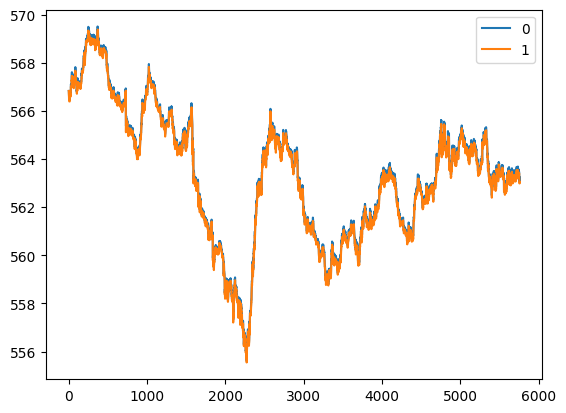

In [405]:
plt.plot(ask, label='0')
plt.plot(ask1, label='1')

plt.legend()

In [392]:
def return_to_standard(obs, price_index, max_leverage):

    impact_margin = 200 * max_leverage
    def impact_price(ob_fut):
        p_i = 0

        price_quant = 0
        quant_sum = 0
        
        for i in range(len(ob_fut)):
            ob = ob_fut
            
            price_quant += ob[i]['price'] * ob[i]['volume']
            quant_sum += ob[i]['volume']
            
            if price_quant > impact_margin:
                price_quant -= ob[i]['price'] * ob[i]['volume']
                quant_sum -= ob[i]['volume']
                p_i = i
                break
                
        result = impact_margin / ((impact_margin - price_quant) / ob_fut[p_i]['price'] + quant_sum)
        return result
    
    def premium_index(impact_bid, impact_ask, index):
        return (max(0, impact_bid - index) - max(0, index - impact_ask)) / index

    fr, prem_index, bid, ask = funding_rate_5s(obs[:len(price_index)], price_index, max_leverage)
    lr = -0.0004
    rr = 0.0006

    sum_buy = []
    sum_sell = []

    for i in range(len(prem_index)):
        index = prem_index[i]
        j = 0
        sum = 0
        while index < lr:
            sum += obs[i]['ask'][j]['price'] * obs[i]['ask'][j]['volume']
            new_ask = impact_price(obs[i]['ask'][j:])
            j += 1
            index = premium_index(bid[i], new_ask, price_index[i])
        sum_buy.append(sum)

        index = prem_index[i]
        j = 0
        sum = 0
        while index > rr:
            sum += obs[i]['bid'][j]['price'] * obs[i]['bid'][j]['volume']
            new_bid = impact_price(obs[i]['bid'][j:])
            j += 1
            index = premium_index(new_bid, ask[i], price_index[i])
        sum_sell.append(sum)

    return sum_buy, sum_sell


In [ ]:
obs_2 = copy.deepcopy(obs)
buy, sell = return_to_standard(obs_2, bch_index, 75)

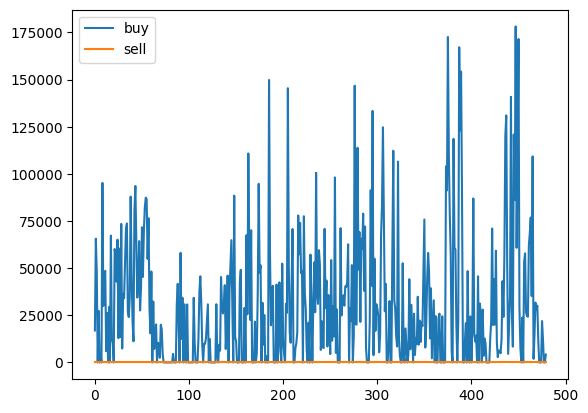

In [404]:
plt.plot(buy[::12], label='buy')
plt.plot(sell[::12], label='sell')

plt.legend();